<a href="https://colab.research.google.com/github/TECH-NINJA06/login-next/blob/master/mcLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
df = pd.read_csv("wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery' ])

In [5]:
df.head()


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [6]:
df = df.dropna(subset=["description", "points"])

In [7]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


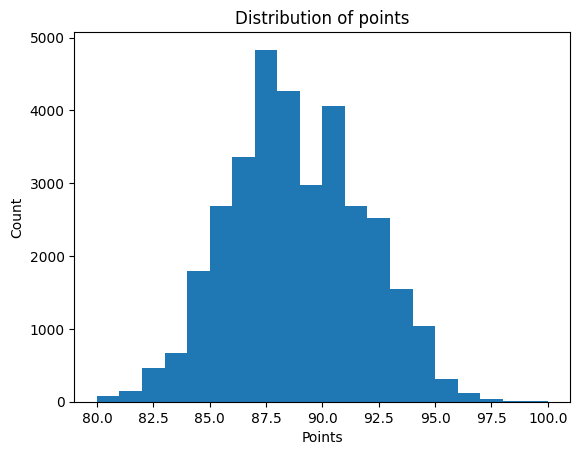

In [9]:
plt.hist(df.points, bins=20)
plt.title("Distribution of points")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()

In [10]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]

In [11]:
df.tail()

,description,points,label
33603,"Linear and elegant, this bears dusty tones of ...",91,1
33604,Honeyed marmalade and bitter orange-rind flavo...,91,1
33605,"This wine represents an excellent value, and o...",91,1
33606,"This is soft, smooth and refined, with rich, c...",91,1
33607,"Bosco Faiano is a hearty, masculine wine, aged...",91,1


In [12]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [13]:
len(train), len(val), len(test)

(26886, 3361, 3361)

In [14]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1000):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [15]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [17]:
list(train_data)[0]

(<tf.Tensor: shape=(1000,), dtype=string, numpy=
 array([b"There's a spicy element of clove or cinnamon (25% of the wine is aged in oak) that is followed by stone fruit and bitter almond. Tonic effervescence and crisp acidity would help pair this wine with quiche.",
        b'Hay yellow in color, with a wispy shade of pink in the core, this bubbly shows aromas of lemon chiffon, sourdough toast, white peach and a touch of quinine on the nose. Lemon peel and curd show strongly on the palate, laid across a salted cracker flavor\xe2\x80\x94quite delicious and refreshing at once.',
        b'A great wine, packed with black currant fruits, sweet tannins and beautiful acidity. Made by the team at L\xc3\xa9oville las Cases, this wine reveals an elegant, restrained structure, ripe and delicious fruit and a darker, tighter texture for aging.',
        b'Quinta do Carmo, formerly owned by the Rothschild family of Ch\xc3\xa2teau Lafite, is now part of the Bacalh\xc3\xa2o group. Perfumed and fruity

To convert our texts to numbers


In [29]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [30]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1000, 50), dtype=float32, numpy=
array([[ 0.20238437,  0.13048507, -0.10762502, ..., -0.19414859,
        -0.00862594, -0.04088451],
       [ 0.36111212, -0.47797346, -0.14103654, ...,  0.13417475,
        -0.11086194, -0.02479712],
       [ 0.44350263,  0.01954609, -0.01513866, ..., -0.20035897,
        -0.4197062 , -0.02658294],
       ...,
       [ 0.14692792, -0.57872933, -0.16224088, ...,  0.02235534,
        -0.0580462 ,  0.0285977 ],
       [ 0.3592064 , -0.13301745,  0.06383111, ...,  0.29790854,
        -0.12619412, -0.05269659],
       [ 0.36304823, -0.13109602, -0.07059064, ..., -0.00470209,
        -0.07406394, -0.00829437]], dtype=float32)>

In [31]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) #added to reduce val_losses
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) #added to reduce val_losses
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
model.evaluate(train_data)

27/27 [==============================] - 1s 12ms/step - loss: 0.6853 - accuracy: 0.5977


[0.6852554082870483, 0.5977460145950317]

In [34]:
model.evaluate(val_data)

4/4 [==============================] - 0s 9ms/step - loss: 0.6857 - accuracy: 0.5930


[0.6857315897941589, 0.592978298664093]

In [35]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

Epoch 1/10
27/27 [==============================] - 40s 1s/step - loss: 0.6780 - accuracy: 0.5812 - val_loss: 0.6546 - val_accuracy: 0.6317
Epoch 2/10
27/27 [==============================] - 36s 1s/step - loss: 0.6424 - accuracy: 0.6344 - val_loss: 0.6176 - val_accuracy: 0.6373
Epoch 3/10
27/27 [==============================] - 38s 1s/step - loss: 0.5936 - accuracy: 0.6750 - val_loss: 0.5534 - val_accuracy: 0.7150
Epoch 4/10
27/27 [==============================] - 38s 1s/step - loss: 0.5293 - accuracy: 0.7340 - val_loss: 0.4879 - val_accuracy: 0.7798
Epoch 5/10
27/27 [==============================] - 36s 1s/step - loss: 0.4687 - accuracy: 0.7662 - val_loss: 0.4481 - val_accuracy: 0.7983
Epoch 6/10
27/27 [==============================] - 36s 1s/step - loss: 0.4197 - accuracy: 0.8031 - val_loss: 0.4267 - val_accuracy: 0.8102
Epoch 7/10
27/27 [==============================] - 36s 1s/step - loss: 0.3832 - accuracy: 0.8352 - val_loss: 0.4191 - val_accuracy: 0.8114
Epoch 8/10
27/27 [==

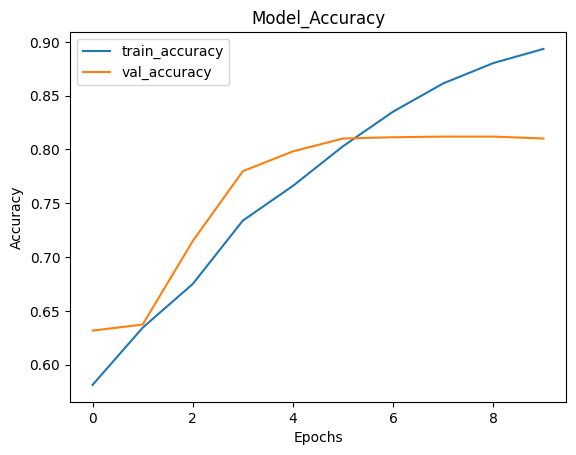

In [36]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model_Accuracy')
plt.legend()
plt.show()

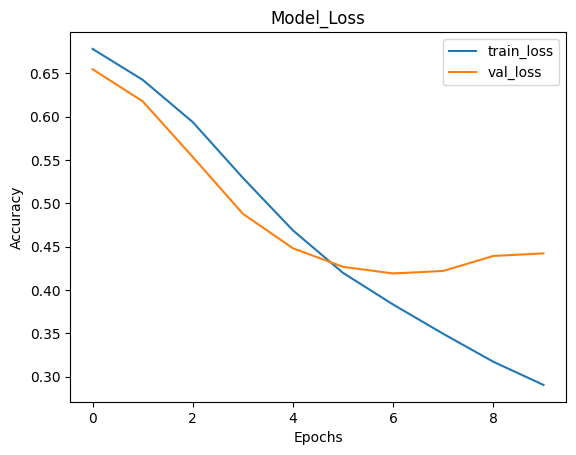

In [37]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model_Loss')
plt.legend()
plt.show()

In [38]:
model.evaluate(test_data)

4/4 [==============================] - 1s 221ms/step - loss: 0.4210 - accuracy: 0.8134


[0.421010822057724, 0.8134483695030212]

LSTM

In [39]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [40]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'in', 'flavors', 'to', 'it', 'its', 'fruit', 'on', 'aromas',
       'palate', 'that'], dtype='<U17')

In [41]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
model.evaluate(train_data)

27/27 [==============================] - 16s 422ms/step - loss: 0.6934 - accuracy: 0.4608


[0.6933833360671997, 0.4608346223831177]

In [44]:
model.evaluate(val_data)

4/4 [==============================] - 1s 203ms/step - loss: 0.6933 - accuracy: 0.4787


[0.6933284401893616, 0.4787265658378601]

In [45]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

Epoch 1/10
27/27 [==============================] - 28s 825ms/step - loss: 0.6602 - accuracy: 0.6268 - val_loss: 0.6229 - val_accuracy: 0.6323
Epoch 2/10
27/27 [==============================] - 27s 997ms/step - loss: 0.5438 - accuracy: 0.7094 - val_loss: 0.4563 - val_accuracy: 0.7923
Epoch 3/10
27/27 [==============================] - 23s 846ms/step - loss: 0.3931 - accuracy: 0.8205 - val_loss: 0.3780 - val_accuracy: 0.8328
Epoch 4/10
27/27 [==============================] - 23s 833ms/step - loss: 0.3478 - accuracy: 0.8458 - val_loss: 0.3742 - val_accuracy: 0.8346
Epoch 5/10
27/27 [==============================] - 23s 849ms/step - loss: 0.3272 - accuracy: 0.8560 - val_loss: 0.3708 - val_accuracy: 0.8298
Epoch 6/10
27/27 [==============================] - 21s 788ms/step - loss: 0.3146 - accuracy: 0.8612 - val_loss: 0.3769 - val_accuracy: 0.8340
Epoch 7/10
27/27 [==============================] - 22s 820ms/step - loss: 0.3034 - accuracy: 0.8658 - val_loss: 0.3840 - val_accuracy: 0.8337

In [46]:
model.evaluate(test_data)

4/4 [==============================] - 2s 433ms/step - loss: 0.3790 - accuracy: 0.8289


[0.3789812922477722, 0.8289199471473694]